In [10]:
# PMM Feature Extraction for UAV using mmWave Radar Data
# This Python script will load binary data files from the mmWave radar,
# perform spectral analysis, and identify Periodic Micro Motions (PMM) features.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal.windows import hamming

# Function to load binary data
def load_binary_data(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data

# Process data in smaller chunks to avoid memory issues
files = ['data/drone_steady_0/master_0000_data.bin', 
         'data/drone_steady_0/slave1_0000_data.bin', 
         'data/drone_steady_0/slave2_0000_data.bin', 
         'data/drone_steady_0/slave3_0000_data.bin']

# with open(files[0], 'rb') as f:
#     data = np.fromfile(f, dtype=np.int16, count=4)
#     print(data.size)


In [11]:
chunk_size = int(1e5)  # Number of samples to process at a time

# Parameters
adc_samples = 256  # Number of samples per chirp
nchirp_loops = 64  # Number of chirps per frame
sample_freq = 8e6  # Sampling frequency in Hz

In [3]:
# Initialize empty list for STFT results
stft_results = []
radar_data_frames = []

# Loop through each file and process data in chunks
for filename in files:
    with open(filename, 'rb') as file_handle:
        while True:
            # Read the data chunk from file
            data_chunk = np.fromfile(file_handle, dtype=np.int16, count=chunk_size)
            if len(data_chunk) == 0:
                break

            # Reshape the chunk into chirps and frames if possible
            num_chirps = len(data_chunk) // adc_samples
            radar_data_chunk = data_chunk[:num_chirps * adc_samples].reshape(adc_samples, num_chirps)
            radar_data_frames.append(radar_data_chunk)

            # Iterate over chirps instead of processing the entire chunk at once
            for chirp in radar_data_chunk.T:
                # FFT parameters
                NFFT = 512  # Reduce FFT points to save memory
                window = hamming(adc_samples)
                overlap = adc_samples // 2

                # Doppler analysis using STFT to extract PMM features for each chirp
                f_vals, t_vals, Zxx = stft(
                    chirp, fs=sample_freq, window=window,
                    nperseg=adc_samples, noverlap=overlap, nfft=NFFT, boundary=None
                )

                # Append STFT results for each chirp, using float32 to save memory
                stft_results.append(np.abs(Zxx).astype(np.float32))

            # Clean up to release memory
            del data_chunk, radar_data_chunk

# Now stft_results contains the reduced memory version of the STFT results


# Concatenate all STFT results
stft_results = np.concatenate(stft_results, axis=1)

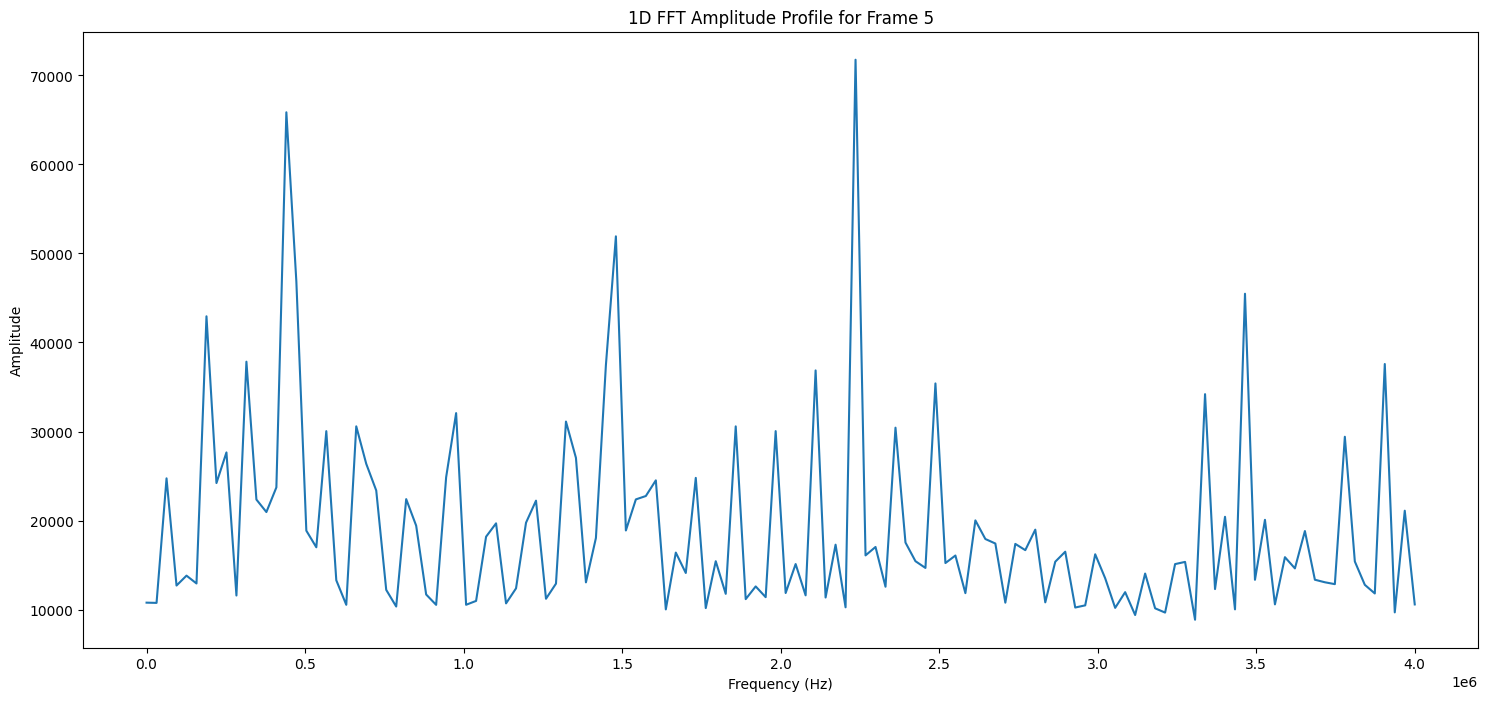

In [5]:
# Function to plot 1D FFT amplitude profile for a selected frame
def plot_fft_amplitude_profile(frame_number):
    if frame_number < 0 or frame_number >= len(radar_data_frames):
        print(f"Invalid frame number. Please select a frame number between 0 and {len(radar_data_frames) - 1}.")
        return
    
    radar_frame = radar_data_frames[frame_number]
    fft_amplitudes = []
    for chirp in radar_frame.T:
        fft_result = np.fft.fft(chirp, n=adc_samples)
        fft_amplitudes.append(np.abs(fft_result[:adc_samples // 2]))
    
    # Plot the FFT amplitude profile
    freq_vector = np.linspace(0, sample_freq / 2, adc_samples // 2)
    plt.figure(figsize=(18, 8))
    plt.plot(freq_vector, np.mean(fft_amplitudes, axis=0))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(f'1D FFT Amplitude Profile for Frame {frame_number}')
    plt.show()

# Example usage: Plot 1D FFT amplitude profile for a selected frame
selected_frame = 5  # Change this to select a different frame
plot_fft_amplitude_profile(selected_frame)